# A* Tree Planner Demo Notebook

## Installs

In [ ]:
!git clone https://github.com/sdean-group/balloon-outreach.git
%cd balloon-outreach
!git checkout main
# Install required packages
!pip install -r requirements.txt

In [ ]:
# ============================================================================
# Imports
# ============================================================================

import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import datetime as dt
import pickle as pkl

from env.balloon_env import BalloonERAEnvironment
from agent.tree_search_agent import run_astar, run_astar_fly_as_far_as_possible, DiscretizeConfig

import importlib.resources as pkg_resources
from pathlib import Path
from env.visualize import plot_trajectory_earth


# For visualization
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)

# For reproducibility
np.random.seed(0)

## WindField and Balloon Environment Initialization

In [3]:
# Configuration parameters, WindField
windfield_noise = False     # Whether to add noise to the wind field.
# Configuration parameters, BalloonERAEnvironment
environment_step = 1200     # Environment step (s)


In [ ]:
# BalloonERAEnvironment initialization 
# 1. Load ERA5 file
from google.colab import drive
import gdown
import os
drive.mount('/content/drive')
path = "/content/drive/MyDrive/era5_data.nc"
if os.path.exists(path):
    print("✅ Found:", path)
    datapath = '/content/drive/My Drive/era5_data.nc'
else:
    print("❌ Not found:", path)
    # Download ERA5 data
    file_id = "1Y5ocrCH0TVf9ZDkVGaJ03ftUrtKEVxIf"
    url = f"https://drive.google.com/uc?id={file_id}"
    output = "era5_data.nc"
    gdown.download(url, output, quiet=False)
    datapath = "/content/balloon-outreach/era5_data.nc"
ds = xr.open_dataset(datapath, engine="netcdf4")
# 2. Pick a reference start_time (should match your dataset’s first valid_time)
start_time = dt.datetime(2024, 7, 1, 0, 0)
# 3. Create environment.
env = BalloonERAEnvironment(ds=ds, start_time=start_time, viz=False, add_noise=windfield_noise, dt=environment_step)
initial_state = env.get_balloon_state()  # Get the initial state of the balloon


WindField initialized with noise enabled: False


## Demo: Fly to Target (Ithaca to Canada)

In [5]:
# Configuration parameters, A*
lat_long_atol = 1e-1        # Tolerance for latitude and longitude (degrees)
alt_atol = 1                # Tolerance for altitude (km)
max_iter = 10000            # Maximum iterations for A* search 
max_depth = None            # Maximum depth for A* search (in discrete timesteps) - None means no limit.
discretization_config = DiscretizeConfig(use_discretization=True, decimals=1)

In [6]:
# Define start and target states
start_state = np.array([42.6, -76.5, 10.0])  # Ithaca
target_state = np.array([47.5, -77, 8])      # Canada

print(f"Start State:  Lat={start_state[0]:.3f}, Lon={start_state[1]:.3f}, Alt={start_state[2]:.1f} km")
print(f"Target State: Lat={target_state[0]:.3f}, Lon={target_state[1]:.3f}, Alt={target_state[2]:.1f} km")


Start State:  Lat=42.600, Lon=-76.500, Alt=10.0 km
Target State: Lat=47.500, Lon=-77.000, Alt=8.0 km


=== Tree Search (A*) Demo ===
Searching for optimal path...
Discretized initial state: [ 42.6 -76.5  10.    0. ]


A* Search Progress:   1%|          | 77/10000 [00:00<00:39, 252.74iteration/s]

A* succeeded! Reconstructing path to target...


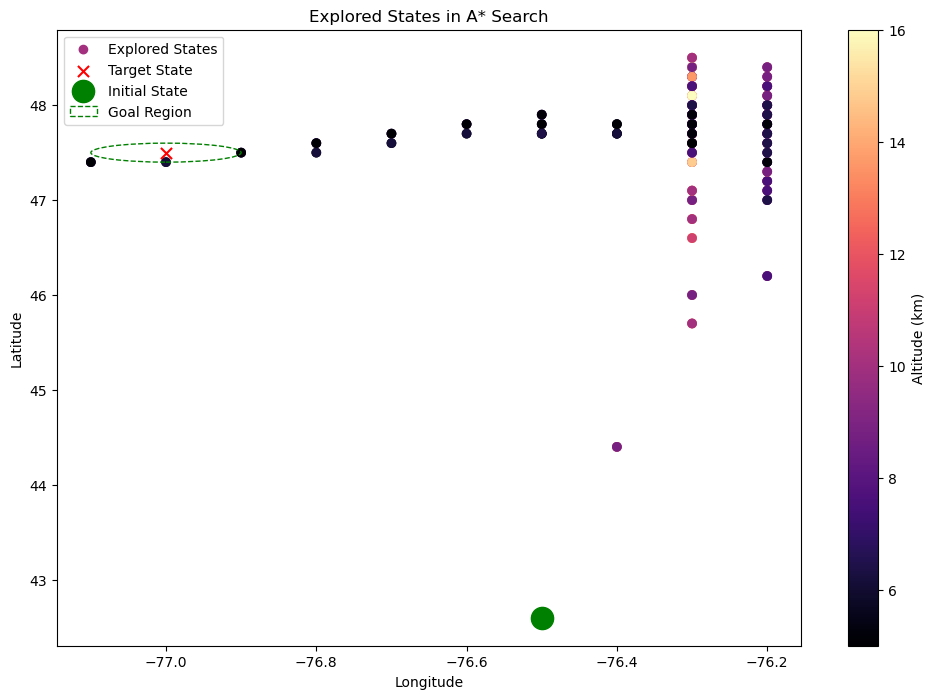

A* Search Progress:   1%|          | 89/10000 [00:00<01:03, 155.83iteration/s]

Action sequence to target: [((np.float64(42.6), np.float64(-76.5), np.float64(10.0), np.float64(0.0)), 'descend'), ((np.float64(44.4), np.float64(-76.4), np.float64(8.8), np.float64(0.3)), 'descend'), ((np.float64(46.2), np.float64(-76.2), np.float64(7.6), np.float64(0.7)), 'descend'), ((np.float64(47.0), np.float64(-76.2), np.float64(6.4), np.float64(1.0)), 'descend'), ((np.float64(47.4), np.float64(-76.2), np.float64(5.2), np.float64(1.3)), 'descend'), ((np.float64(47.6), np.float64(-76.3), np.float64(5.0), np.float64(1.7)), 'stay'), ((np.float64(47.7), np.float64(-76.4), np.float64(5.0), np.float64(2.0)), 'stay'), ((np.float64(47.7), np.float64(-76.5), np.float64(5.0), np.float64(2.3)), 'stay'), ((np.float64(47.7), np.float64(-76.6), np.float64(5.0), np.float64(2.7)), 'stay'), ((np.float64(47.6), np.float64(-76.7), np.float64(5.0), np.float64(3.0)), 'ascend'), ((np.float64(47.5), np.float64(-76.8), np.float64(6.2), np.float64(3.3)), 'ascend'), ((np.float64(47.5), np.float64(-76.9), 

<Figure size 1200x800 with 0 Axes>

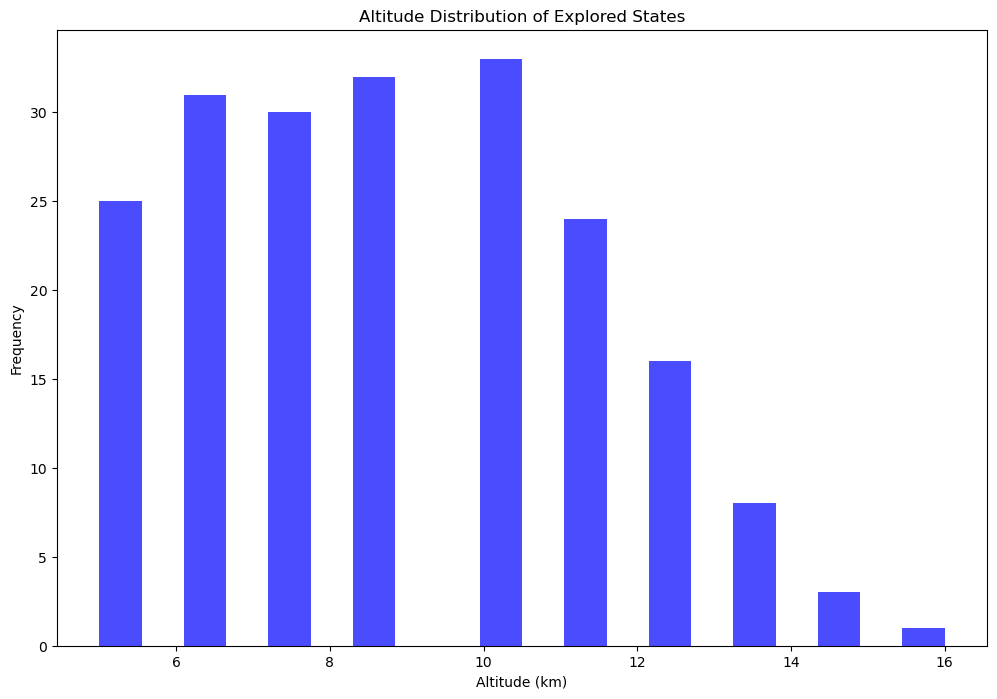

In [7]:
# ============================================================================
# Tree Search Demo
# ============================================================================

# Tree Search Demo
print("=== Tree Search (A*) Demo ===")

# Find optimal path
print("Searching for optimal path...")
# Reset the environment to the initial state
env.set_balloon_state(initial_state)
optimal_path = run_astar(env, initial_lat=start_state[0], initial_long=start_state[1], initial_alt=start_state[2],
            target_lat=target_state[0], target_lon=target_state[1], target_alt=target_state[2],
            distance='haversine', heuristic='haversine',
            plot_suffix="test_era_notebook", simplified_step=True,
            lat_long_atol=lat_long_atol, alt_atol=alt_atol, max_iter=max_iter, max_depth=max_depth,
            discretize_config=discretization_config)

if optimal_path:
    print(f"Found path with {len(optimal_path)} steps")
    print("Path:")
    for i, state in enumerate(optimal_path):
        print(f"  Step {i}: Lat={state[0][0]:.3f}, Lon={state[0][1]:.3f}, Alt={state[0][2]:.1f} km, Action={state[1]}")
else:
    print("No path found within iteration limit")

In [ ]:
# Save the optimal path to disk!
pkl.dump(optimal_path, open("optimal_path_target.pkl", "wb"))

### Visualization!

In [ ]:
# Robustly locate the texture image. Works for both namespace packages and local runs.
try:
    texture_path = pkg_resources.files("env").joinpath("figs/2k_earth_daymap.jpg")
except Exception:
    texture_path = Path(__file__).resolve().parent / "env" / "figs" / "2k_earth_daymap.jpg"

In [ ]:
if optimal_path:
    lats, lons, altitudes = zip(*[(state[0][0], state[0][1], state[0][2]) for state in optimal_path])

    try:
        plot_trajectory_earth(
            lats,
            lons,
            altitudes,
            texture_path=str(texture_path),
            lon_offset_deg=210,
            flip_lat=True,
        )
    except Exception as e:
        print(f"Plotly 3D visualization failed: {e}")

## Demo: Fly As Far As Possible

In [8]:
# Configuration parameters, A*
lat_long_atol = 1e-1        # Tolerance for latitude and longitude (degrees)
alt_atol = 1                # Tolerance for altitude (km)
max_iter = 10000            # Maximum iterations for A* search 
max_depth = 10            # Maximum depth for A* search (in discrete timesteps) - None means no limit.
discretization_config = DiscretizeConfig(use_discretization=True, decimals=1)

In [9]:
# Define start state.
start_state = np.array([42.6, -76.5, 10.0])  # Ithaca

=== Tree Search (A*) Demo ===
Searching for optimal path...
Discretized initial state: [ 42.6 -76.5  10.    0. ]


A* Search Progress:  69%|██████▉   | 6945/10000 [00:26<00:11, 260.05iteration/s]


A* completed. Returning best action sequence found.


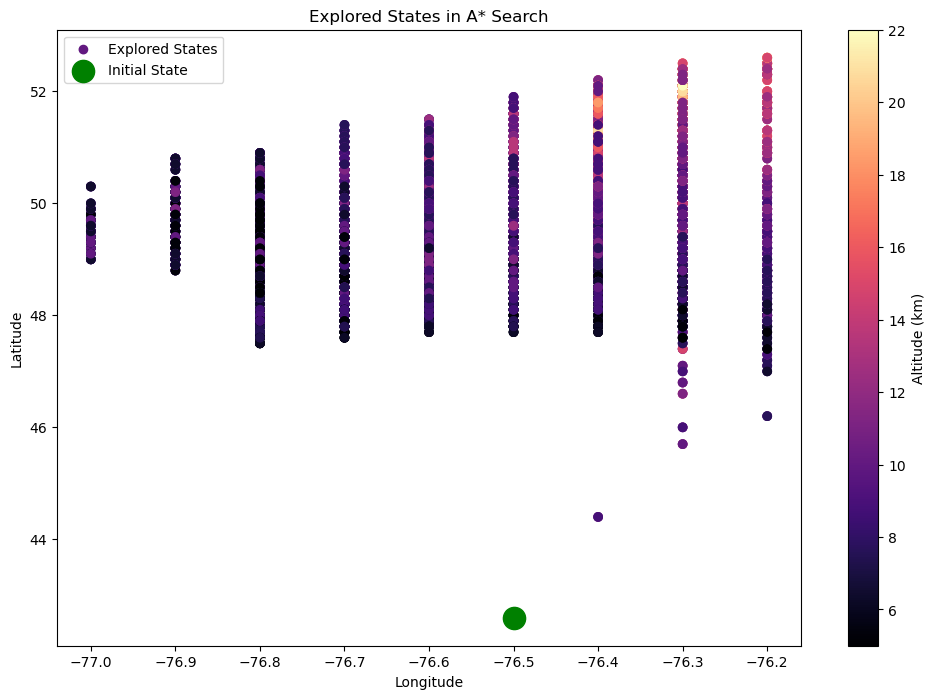

Action sequence (flying as far as possible): [((np.float64(42.6), np.float64(-76.5), np.float64(10.0), np.float64(0.0)), 'descend'), ((np.float64(44.4), np.float64(-76.4), np.float64(8.8), np.float64(0.3)), 'ascend'), ((np.float64(46.2), np.float64(-76.2), np.float64(10.0), np.float64(0.7)), 'ascend'), ((np.float64(47.3), np.float64(-76.2), np.float64(11.2), np.float64(1.0)), 'ascend'), ((np.float64(48.2), np.float64(-76.2), np.float64(12.4), np.float64(1.3)), 'ascend'), ((np.float64(48.9), np.float64(-76.2), np.float64(13.6), np.float64(1.7)), 'ascend'), ((np.float64(49.6), np.float64(-76.2), np.float64(14.8), np.float64(2.0)), 'ascend'), ((np.float64(50.4), np.float64(-76.2), np.float64(16.0), np.float64(2.3)), 'ascend'), ((np.float64(51.2), np.float64(-76.2), np.float64(17.2), np.float64(2.7)), 'ascend'), ((np.float64(51.9), np.float64(-76.2), np.float64(18.4), np.float64(3.0)), 'descend'), ((np.float64(52.6), np.float64(-76.2), np.float64(17.2), np.float64(3.3)), None)]
Found path 

<Figure size 1200x800 with 0 Axes>

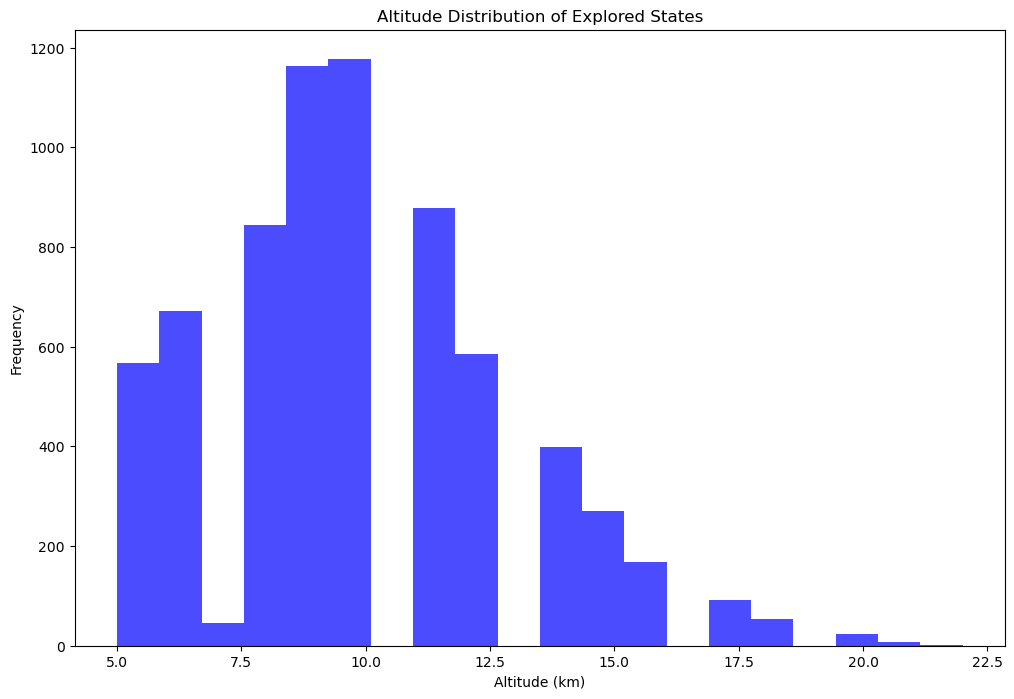

In [10]:
# Tree Search Demo
print("=== Tree Search (A*) Demo ===")

# Find optimal path
print("Searching for optimal path...")
# Reset the environment to the initial state
env.set_balloon_state(initial_state)
optimal_path = run_astar_fly_as_far_as_possible(env, initial_lat=start_state[0], initial_long=start_state[1], initial_alt=start_state[2],
            plot_suffix="test_era_notebook", simplified_step=True,
            max_iter=max_iter, max_depth=max_depth, discretize_config=discretization_config)

if optimal_path:
    print(f"Found path with {len(optimal_path)} steps")
    print("Path:")
    for i, state in enumerate(optimal_path):
        print(f"  Step {i}: Lat={state[0][0]:.3f}, Lon={state[0][1]:.3f}, Alt={state[0][2]:.1f} km, Action={state[1]}")
else:
    print("No path found within iteration limit")

In [ ]:
# Save the optimal path to disk!
pkl.dump(optimal_path, open("optimal_path_flyasfaraspossible.pkl", "wb"))

### Visualization!

In [11]:
# Robustly locate the texture image. Works for both namespace packages and local runs.
try:
    texture_path = pkg_resources.files("env").joinpath("figs/2k_earth_daymap.jpg")
except Exception:
    texture_path = Path(__file__).resolve().parent / "env" / "figs" / "2k_earth_daymap.jpg"
if optimal_path:
    lats, lons, altitudes = zip(*[(state[0][0], state[0][1], state[0][2]) for state in optimal_path])

In [ ]:
try:
    plot_trajectory_earth(
        lats,
        lons,
        altitudes,
        texture_path=str(texture_path),
        lon_offset_deg=210,
        flip_lat=True,
    )
except Exception as e:
    print(f"Plotly 3D visualization failed: {e}")